In [18]:
import random
import math
from tqdm import tqdm_notebook
import itertools
from GeneticAlgorithm import *
from ctrnn import *
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

plt.style.use("dark_background")

In [19]:
#w_ji connections
#i is the current neuron
#j is the other neuron

In [20]:
def getRandomWeight():
    return random.uniform(-15, 15)

def getRandomBias():
    return random.uniform(-15, 15)

def getRandomTau():
    return random.uniform(0.1, 1)

def getRandomState():
    return random.uniform(-5, 5)

#make the individual
class NetworkIndividual(AbstractLinkedListIndividual):
    def __init__(self, neuron_count = 5):
        self.genotype = []
        self.encode_network(neuron_count)
        
    def encode_network(self, neuron_count):
        self.neuron_count = neuron_count
        
        #bias
        bias_ls = [getRandomBias() for i in range(self.neuron_count)]
        #tau
        tau_ls = [getRandomTau() for i in range(self.neuron_count)]
        #states
        state_ls = [getRandomState() for i in range(self.neuron_count)]
        #weights
        weight_ls = [getRandomWeight() for i in range(self.neuron_count * self.neuron_count)]
            
        #genotypeItertool = itertools.chain([self.neuron_count], bias_ls, tau_ls, state_ls, weight_ls)
        #self.genotype = list(genotypeItertool)
        self.genotype = [self.neuron_count]
        self.genotype.extend(bias_ls)
        self.genotype.extend(tau_ls)
        self.genotype.extend(state_ls)
        self.genotype.extend(weight_ls)
        
    def mutate(self, mutation_rate):
        
        bias_offset = 1
        tau_offset = bias_offset + self.neuron_count
        state_offset = tau_offset + self.neuron_count
        weight_offset = state_offset + self.neuron_count
        
        #Skip over the neuron_count in genome
        #TODO: Change this to use the new mutation that is less like random search
        for i in range(bias_offset, len(self.genotype)):
            if random.random() < mutation_rate:
                if i >= weight_offset:
                    self.genotype[i] = getRandomWeight()
                elif i >= state_offset:
                    self.genotype[i] = getRandomState()
                elif i >= tau_offset:
                    self.genotype[i] = getRandomTau()
                elif i >= bias_offset:
                    self.genotype[i] = getRandomBias()

In [27]:
#make the individual
class OscillatingNetworkIndividual(NetworkIndividual):
    def __init__(self, neuron_count = 3):
        self.genotype = []
        self.encode_network(neuron_count)
    
    def fitness(self):
        n = FullyConnectedCTRNN.create_network(self.genotype)
        
        abs_slope_totals = [0.0 for i in range(len(n.neurons))]
        last_output = []
        
        step_size = 0.1
        step_count = 15
        outputs = [n.euler_step(None, step_size) for i in range(step_count)]
        
        for i in range(1, len(outputs)):
            #Sum of total changes in slopes
            for j in range(len(n.neurons)):
                slope = outputs[i-1][j] - outputs[i][j]
                abs_slope_totals[j] += abs(slope)
        
        #Use slope totals to determine if neuron should be oscillating
        output = 0.0
        #A neuron that has a total slope of 500% of the x distance traversed is considered oscillating, partial credit is received
        for abs_slope_total in abs_slope_totals:
            output += min(abs_slope_total / (2 * step_count * step_size), 1.0) #Max is 1.0
            #print("fitness a:", fitness)
        output /= len(n.neurons) #Make each neuron only worth part of the fitness
        #print("fitness b:", fitness)
        return output #normalizze fitness out of [0, 1.0]

In [45]:
def graph_highest_fitness(pop, gen_count):
    test_network = FullyConnectedCTRNN.create_network(pop.fittest_individual.genotype)
    print("weights: [")
    for neuron in test_network.neurons:
        print("\t", neuron.weights)
    print("]")
    print("taus:", [neuron.tau for neuron in test_network.neurons])
    print("bias:", [neuron.bias for neuron in test_network.neurons])
    
    x = []
    y = []
    
    time_step = 0.1
    step_count = 15
    for i in range(step_count):
        x.append(time_step * i)
        y.append(test_network.euler_step(None, time_step))

    #Plot output of each neuron
    plt.title("Output of neurons")
    plt.plot(x, y, '-')
    plt.ylim(0.0, 1.1)
    plt.ylabel("output")
    plt.xlabel("time step")
    plt.show()
    
    #Highest performing over time plot
    #plt.title("Best performing per generation")
    #for point in pop.best_performing_per_generation:
    plt.title("Best performing per generation")
    plt.plot(*zip(*pop.best_performing_per_generation), '.', markersize=12)
    plt.xlim(0, gen_count)
    plt.ylim(0, 1.1)
    plt.ylabel("fitness")
    plt.xlabel("generation")
    plt.show()
    
    print("\n\n\n\n\n")

In [29]:
# %%prun -s cumulative -q -l 10 -T prun4
population_size = 100
gen_count = 3000

population_count = 20
populations = [TournamentPopulation(OscillatingNetworkIndividual, population_size) for i in range(population_count)]
#Builds 20 seperate populations
for i in tqdm_notebook(range(len(populations))):
    pop = populations[i]
    for gen in range(gen_count):
        pop.run_cycle(gen=gen)
        
print("Finished building populations")

Finished building populations


Top 5 performing
weights: [
	 [-1.0050973141854347, 4.964939850786207, -3.1805863467517237]
	 [-6.020899014839479, -7.0185308492982585, 12.905817214136608]
	 [11.288585544164825, -11.94136662739057, -10.875943405020749]
]
taus: [0.2481876989769395, 0.19509366088971475, 0.11980200404342353]
bias: [0.24117359970504104, 2.959219764771433, 1.7273449513538104]


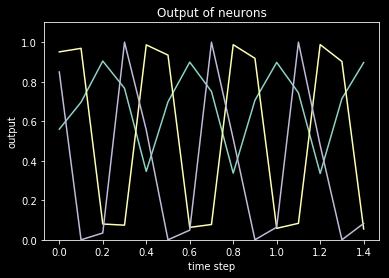

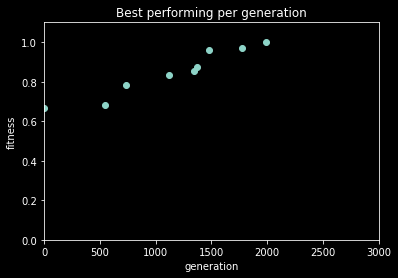







weights: [
	 [1.7910797074885654, -0.2395186273721217, -3.6268719204892728]
	 [3.1111336147925677, -5.904083619198568, 13.1698049218584]
	 [-1.507959737757691, 8.236987493649469, -10.577115730516924]
]
taus: [0.16111747906929097, 0.12759627968378887, 0.12947127641875172]
bias: [0.30914472114222313, -10.293864483466727, 2.694036367371176]


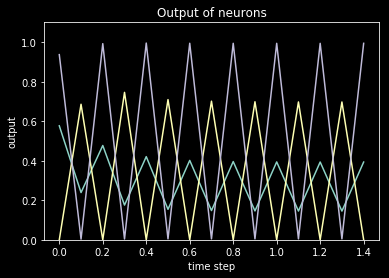

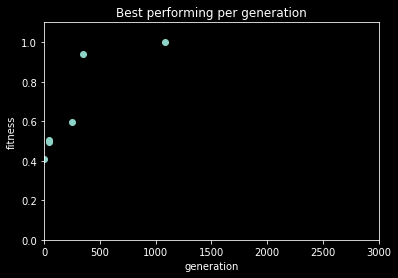







weights: [
	 [3.425791222817942, -4.65515973666653, -3.1068239257294508]
	 [9.899209249354772, -14.499775983632786, -12.852656302981341]
	 [-1.7549656294339329, 12.003354443724334, -7.028822164782297]
]
taus: [0.11025440941615261, 0.1647723658617247, 0.2200291733337765]
bias: [-0.04530757381422568, 2.1593606086093047, -0.6610321058897366]


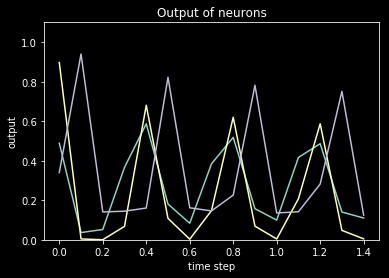

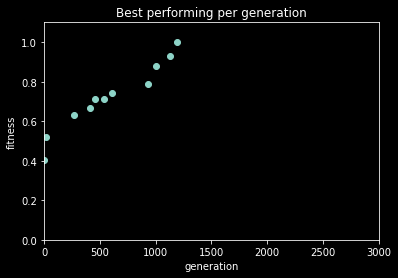







weights: [
	 [-2.5564879774840032, 3.2600264116556392, -4.604969714486985]
	 [-14.479887050054653, -9.486610798768641, 5.590680593740874]
	 [8.277462402421442, 12.013345798314909, -12.562425660524873]
]
taus: [0.47207164491090425, 0.10200561180471814, 0.13046911741327347]
bias: [1.4784069725715376, 11.54800608165431, -3.805349049316444]


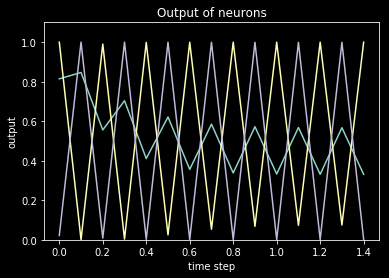

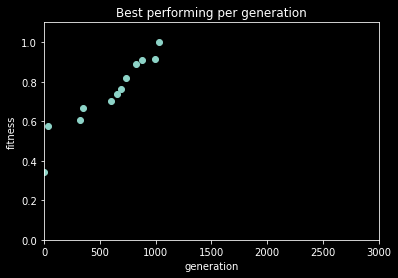







weights: [
	 [-2.4553721981707435, -4.0853679989314955, -2.3039220171767205]
	 [4.468405023458864, -3.1980105389356748, -14.058149088162969]
	 [8.971871244107476, 9.441489052757262, -12.613714189175562]
]
taus: [0.19687524468582396, 0.11590825454023759, 0.26034832776164285]
bias: [1.9513752545963392, 5.961389857446161, 1.4239801812530004]


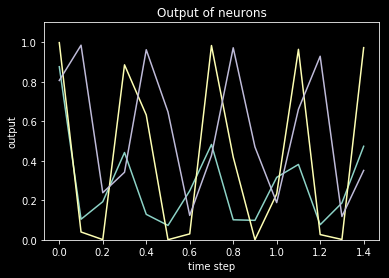

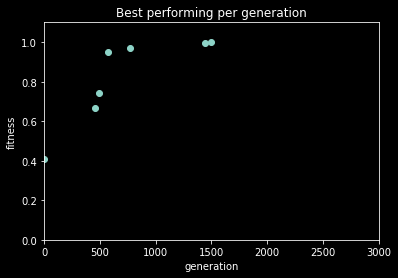

In [46]:
print("Top 5 performing")
#Sort populations by fitness
sorted_populations = sorted(populations, key=lambda pop: pop.fittest_individual.fitness() , reverse=True)
#Print top 5 populations? Not sure what to do if multi get perfect points
for pop in sorted_populations[0:5]:
    graph_highest_fitness(pop, gen_count)
    #print(pop.highest_fitness, "==", pop.fittest_individual.fitness())

In [44]:
"""print("Runs for", gen_count, "reproductions/mutations aka generations")
print("Base population contains", population_size, "individuals")
print("Initial populations built with weights [-15,15], biases [-15,15], taus [0.1, 1], and states [-5, 5]")
print("Created 20 seperate populations")
print("Fitness is in the range of [0.0, 1.0]")"""

'print("Runs for", gen_count, "reproductions/mutations aka generations")\nprint("Base population contains", population_size, "individuals")\nprint("Initial populations built with weights [-15,15], biases [-15,15], taus [0.1, 1], and states [-5, 5]")\nprint("Created 20 seperate populations")\nprint("Fitness is in the range of [0.0, 1.0]")'